###  Implementation of a Low Pass FIR Filter with DMAs in SDSoC Ported to python
##### Source : https://github.com/hackwa/pynqfire

In [1]:
import numpy as np
# Example Dataset
T = 5.0         # seconds
fs = 30.0
n = int(T * fs) # total number of samples
t = np.linspace(0, T, n, endpoint=False)
samples = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) + 0.5*np.sin(12.0*2*np.pi*t)

### Hardware Implementation

In [2]:
from fir import fir
accel = fir()

In [3]:
# Hardware design keeps state in the IP. Reset.
accel.reset()

In [4]:
# Define/Load coefficients
fname = "cpp_FIR.inc"
with open(fname, "r") as f:
    coefs = f.readlines()
coefs = np.array([int(x.strip()[:-1]) for x in coefs]).astype("int32")

In [5]:
# Allocate physical contiguous memory
din = accel.mem_init(n*4)
win = accel.mem_init(len(coefs)*4)
dout = accel.mem_init(n*4)
dlen = n
# Sample Input data
for i in range(0,n):
    din[i] = int(samples[i] * 100)
for i in range(0, len(coefs)):
    win[i] = int(coefs[i])

In [6]:
# Call Accelerator
accel.get_response(din, win, dout, dlen)

<IPython.core.display.Javascript object>


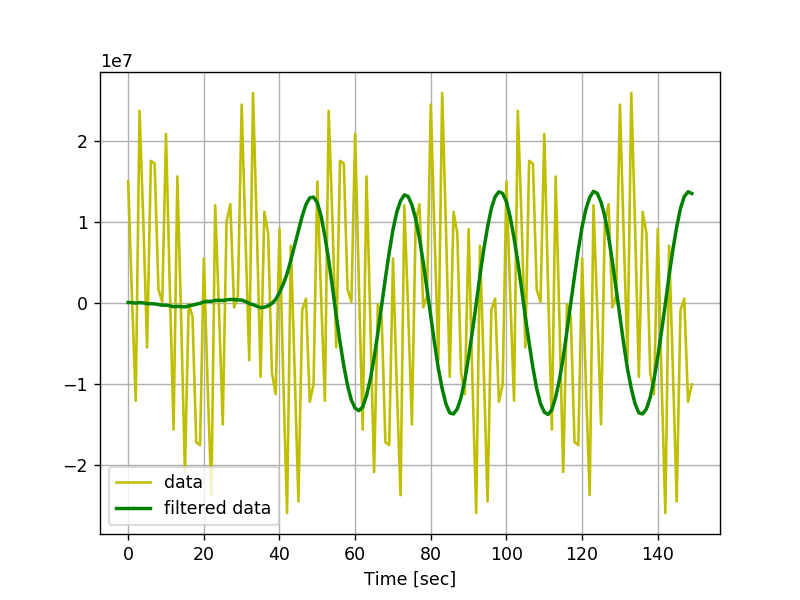

In [7]:
%matplotlib notebook
import matplotlib.pyplot as plt
output = []
for i in range(0,n):
    output.append(dout[i])

plt.subplot(1, 1, 1)
plt.xlabel('Time [sec]')
plt.grid()
plt.plot([int(x*10000000) for x in samples],'y-',label='data')
plt.plot(output,'g-',linewidth=2,label='filtered data')
plt.legend()

### Software Implementation of filter found at:
http://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units (Benchmarks and Outputs using the same data as that used by hardware design) Total input samples= 150

In [8]:
%matplotlib notebook
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Filter requirements.
order = 7
fs = 30.0       # sample rate, Hz
cutoff = 3.667  # desired cutoff frequency of the filter, Hz

<IPython.core.display.Javascript object>


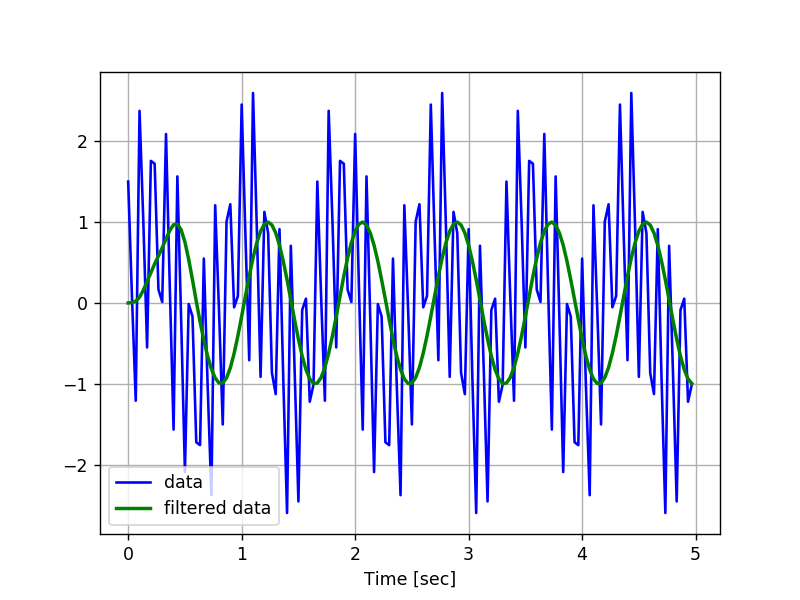

In [9]:
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')

# Generate Samples
samples = np.sin(1.2*2*np.pi*t) + 1.5*np.cos(9*2*np.pi*t) + 0.5*np.sin(12.0*2*np.pi*t)

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(samples, cutoff, fs, order)

plt.subplot(1, 1, 1)
plt.plot(t, samples, 'b-', label='data')
plt.plot(t, y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()
plt.subplots_adjust(hspace=0.35)

### Benchmarks

In [10]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

number = 2000
samples = [0]*1000
n = 1000
print("Comparing Hardware processing of",n,"samples to software")
din = accel.mem_init(n*4)
win = accel.mem_init(85)
dout = accel.mem_init(n*4)
print("Initializing random samples")
for i in range(0,n):
    data =  np.random.randint(n)
    data_w = np.random.randint(n)
    if i < 85:
        win[i] = data_w
    din[i] = data
    samples[i] = data    
dlen = n
def hwresp():
        accel.get_response(din,win,dout,dlen)
def swresp():
    butter_lowpass_filter(samples, cutoff, fs, order)
print("Running the benchmarks")
import timeit
print("Time taken by hardware to run", number,"times",timeit.timeit(hwresp,number=number))
print("Time taken by software to run", number,"times",timeit.timeit(swresp,number=number))

Comparing Hardware processing of 1000 samples to software
Initializing random samples
Running the benchmarks
Time taken by hardware to run 2000 times 10.608616114000142
Time taken by software to run 2000 times 11.288647548999506


<IPython.core.display.Javascript object>


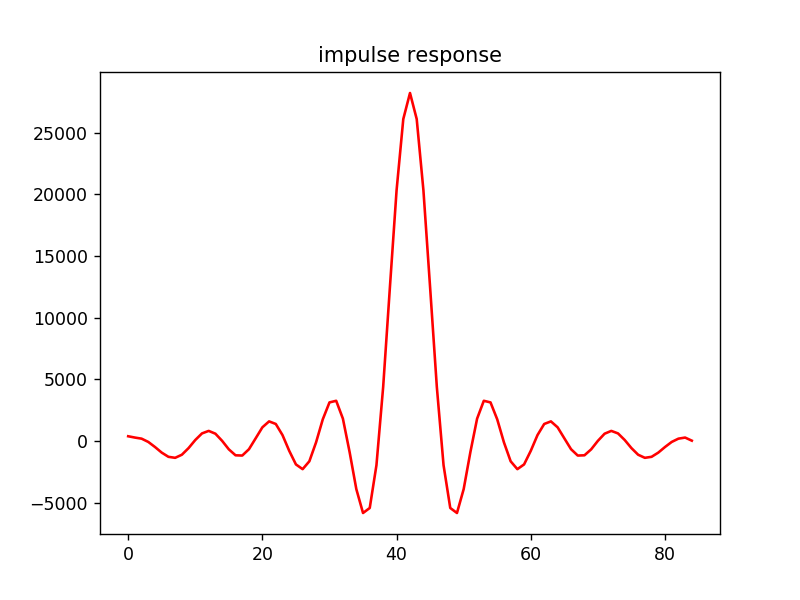

Text(0.5,1,'impulse response')

In [11]:
%matplotlib notebook
import matplotlib.pyplot as plt

n = 85
output=[]
din = accel.mem_init(n*4)
dout = accel.mem_init(n*4)
win = accel.mem_init(85)
for i in range(0, len(coefs)):
    win[i] = int(coefs[i])
# Reset
accel.reset()
din[0] = 1
accel.get_response(din,win,dout,n)
for i in range(0,n):
    output.append(dout[i]) 
plt.plot(output,'r')
plt.title('impulse response')